<a href="https://colab.research.google.com/github/interestingsanskar07/Multi-class-classification-on-Stack-Overflow-questions/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: **multi-class classification on Stack Overflow questions**

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k_v1", url,
                                    untar=True, cache_dir='stack_overflow',
                                    cache_subdir='.')
dataset_dir = os.path.join(os.path.dirname(dataset))

In [ ]:
os.listdir(dataset_dir)

['stack_overflow_16k_v1.tar.gz', 'test', 'README.md', 'train']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'python', 'java', 'javascript']

In [ ]:
sample_file = os.path.join(train_dir, 'python/118.txt')
with open(sample_file) as f:
  print(f.read())

"what's the correct way to change a value that is imported by other modules? i have my entry point script take a cli option argument using argsparser and that looks something like this:..    import some_module..    if __name__== ""__main__"":.        parser = argparse.argumentparser(description='nemo node.').        parser.add_argument('-t', '--test', dest='testing', action=""store_true"")..        # handle cli params and options.        # .......        some_module.run()...i want the -t option to change a parameter testing in a config script settings.py, since my some_module uses things like :..from settings import testing.if testing:.   # do some testing stuff...because of this testing is already imported into some_module by the time i handle the args, changes to settings.py can no longer have any effect on some_module..my answer is what's the correct practice in dealing with this:...import some_module inside the __main__ after the args have been parsed?.replace testing by settings.t

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    validation_split=0.2,
    subset='validation',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print("Question: ", text_batch.numpy()[i])
        print("Label:", label_batch.numpy()[i])

Question:  b'"language change with keydown event on all form i develop an application that can change language between english and hungarian. this software work with .resx files and when the user presses f2 the labels, buttons, and other controls their text properties will be changed from the .resx file. ..it\'s ok, but when i have more than one form open, naturally the keydown event changes those controls that are in the focused form. so my question is: how can i capture the f2 keystroke in all opened forms?"\n'
Label: 0
Question:  b'bubble sort without using temporary variable i want to sort both 1 dimensional and 2 dimensional array without using temp variable in blank..how to do it can anyone suggest\n'
Label: 1
Question:  b'"declaring array as public in main and accessing it in other class i want to know how to create/declare the array as public in main class and then access it in other class. the few lines of code of my programs are: ..main class..import blank.util.*; .import bla

In [ ]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_size_vocab = 10000
max_sequence_length = 250
binary_vectorize_layer = layers.TextVectorization(
    max_tokens=max_size_vocab,
    output_mode='binary')

In [ ]:
int_vectorize_layer = layers.TextVectorization(
  max_tokens=max_size_vocab,
  output_mode='int',
  output_sequence_length=max_sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [ ]:
def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [ ]:
binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)
binary_test_ds = raw_test_ds.map(binary_vectorize_text)
int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)
binary_test_ds = configure_dataset(binary_test_ds)
int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)


In [ ]:
from tensorflow.python.ops.control_flow_ops import from_control_flow_context_def
binary_model = tf.keras.Sequential([layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy']
)

history = binary_model.fit(
    binary_train_ds,validation_data=binary_val_ds, epochs=10
)

Epoch 1/10
200/200 [==============================] - 4s 15ms/step - loss: 1.1228 - accuracy: 0.6458 - val_loss: 0.9146 - val_accuracy: 0.7763
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.7795 - accuracy: 0.8205 - val_loss: 0.7499 - val_accuracy: 0.7975
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6277 - accuracy: 0.8611 - val_loss: 0.6641 - val_accuracy: 0.8144
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5342 - accuracy: 0.8861 - val_loss: 0.6106 - val_accuracy: 0.8225
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4681 - accuracy: 0.9055 - val_loss: 0.5739 - val_accuracy: 0.8306
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4178 - accuracy: 0.9169 - val_loss: 0.5472 - val_accuracy: 0.8331
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3776 - accuracy: 0.9275 - val_loss: 0.5271 - val_accuracy: 0.8375
Epoch

In [ ]:
# Creating a plot of accuracy and loss over time
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

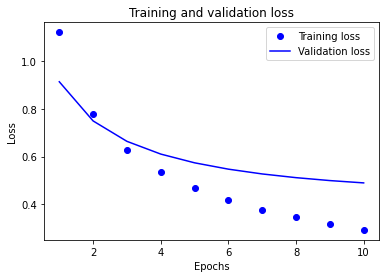

In [ ]:

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

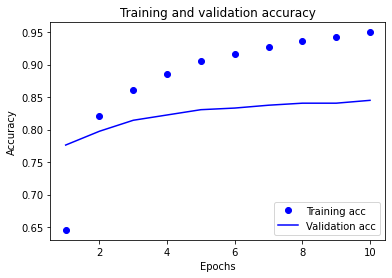

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
def create_model(vocab_size, num_labels):
  model = tf.keras.Sequential([
    layers.Embedding(vocab_size, 64, mask_zero=True),
    layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
    layers.GlobalMaxPooling1D(),
    layers.Dense(num_labels)
    ])
  return model

In [ ]:


int_model = create_model(vocab_size=max_size_vocab + 1, num_labels=4)
int_model.compile(
  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'])
history = int_model.fit(int_train_ds, validation_data=int_val_ds,epochs=5)

Epoch 1/5
200/200 [==============================] - 8s 37ms/step - loss: 1.1353 - accuracy: 0.5141 - val_loss: 0.7624 - val_accuracy: 0.6950
Epoch 2/5
200/200 [==============================] - 5s 27ms/step - loss: 0.6174 - accuracy: 0.7606 - val_loss: 0.5421 - val_accuracy: 0.7919
Epoch 3/5
200/200 [==============================] - 7s 34ms/step - loss: 0.3787 - accuracy: 0.8786 - val_loss: 0.4822 - val_accuracy: 0.8219
Epoch 4/5
200/200 [==============================] - 5s 27ms/step - loss: 0.2152 - accuracy: 0.9488 - val_loss: 0.4798 - val_accuracy: 0.8194
Epoch 5/5
200/200 [==============================] - 5s 27ms/step - loss: 0.1096 - accuracy: 0.9805 - val_loss: 0.5044 - val_accuracy: 0.8175


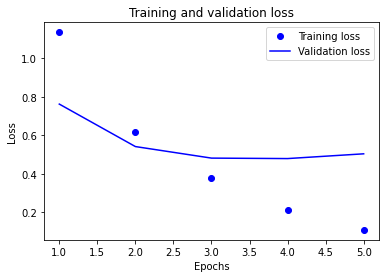

In [ ]:
# Creating a plot of accuracy and loss over time
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

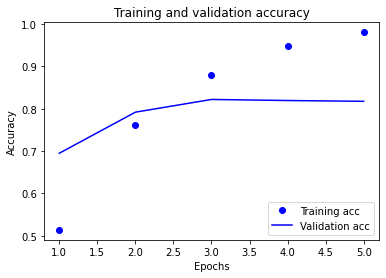

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
print("Linear model on binary vectorized data:")
print(binary_model.summary())

Linear model on binary vectorized data:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 40004     
                                                                 
Total params: 40,004
Trainable params: 40,004
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print("Conventional model on integer vectorized data:")
print(int_model.summary())

Conventional model on integer vectorized data:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 conv1d (Conv1D)             (None, None, 64)          20544     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 660,868
Trainable params: 660,868
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
binary_loss, binary_accuracy = binary_model.evaluate(binary_test_ds)
int_loss, int_accuracy, = int_model.evaluate(int_test_ds)
print("Binary model accuracy : {:2.2%}".format(binary_accuracy))
print("Integer model accuracy : {:2.2%}".format(int_accuracy))

250/250 [==============================] - 4s 14ms/step - loss: 0.5239 - accuracy: 0.8049
Binary model accuracy : 81.42%
Integer model accuracy : 80.49%


In [ ]:
export_model = tf.keras.Sequential([
  binary_vectorize_layer, binary_model,
  layers.Activation('sigmoid')])
  
export_model.compile(
  loss=losses.SparseCategoricalCrossentropy(from_logits=False),optimizer='adam',metrics=['accuracy'])


# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(binary_accuracy))

250/250 [==============================] - 3s 11ms/step - loss: 0.5175 - accuracy: 0.8142
Accuracy: 81.42%


In [ ]:
# Inferencing on new data
def get_string_labels(predicted_scores_batch):
  predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
  predicted_labels = tf.gather(raw_train_ds.class_names,
                               predicted_int_labels)
  return predicted_labels

inputs = [
       "how do I extract keys from a dict into a list?", 
       "debug public static void main(string[] args) {...}",
       ]
predicted_scores = export_model.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)
for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

Question:  how do I extract keys from a dict into a list?
Predicted label:  b'python'
Question:  debug public static void main(string[] args) {...}
Predicted label:  b'java'
